In [2]:
import scipy.io.wavfile as wavio
import numpy as np
import scipy.signal as sig
import IPython
import matplotlib.pyplot as plt


sample_rate = 48000
duration = 2
# C4 @ 260Hz
c4 = np.linspace(0, 260 * duration, sample_rate * duration)
c4 = np.sin(2 * np.pi * c4)
# E4 @ 330Hz
e4 = np.linspace(0, 330 * duration, sample_rate * duration)
e4 = np.sin(2 * np.pi * e4)
# G4 @ 392Hz
g4 = np.linspace(0, 392 * duration, sample_rate * duration)
g4 = np.sin(2 * np.pi * g4)
# Triad
harmo_i = c4 + e4 + g4
IPython.display.display(IPython.display.Audio(harmo_i, rate=sample_rate))

In [3]:
# DTMF
duration = 1/4
# Columns
hz_1209 = np.linspace(0, int(1209 * duration), int(sample_rate * duration))
hz_1209 = np.sin(2 * np.pi * hz_1209)
hz_1336 = np.linspace(0, int(1336 * duration), int(sample_rate * duration))
hz_1336 = np.sin(2 * np.pi * hz_1336)
hz_1477 = np.linspace(0, int(1477 * duration), int(sample_rate * duration))
hz_1477 = np.sin(2 * np.pi * hz_1477)
# Rows
hz_697 = np.linspace(0, int(697 * duration), int(sample_rate * duration))
hz_697 = np.sin(2 * np.pi * hz_697)
hz_770 = np.linspace(0, int(770 * duration), int(sample_rate * duration))
hz_770 = np.sin(2 * np.pi * hz_770)
hz_852 = np.linspace(0, int(852 * duration), int(sample_rate * duration))
hz_852 = np.sin(2 * np.pi * hz_852)
hz_941 = np.linspace(0, int(941 * duration), int(sample_rate * duration))
hz_941 = np.sin(2 * np.pi * hz_941)
# Numbers
one = hz_1209 + hz_697
two = hz_1336 + hz_697
three = hz_1477 + hz_697
four = hz_1209 + hz_770
five = hz_1336 + hz_770
six = hz_1477 + hz_770
seven = hz_1209 + hz_852
eight = hz_1336 + hz_852
nine = hz_1477 + hz_852
star = hz_1209 + hz_941
zero = hz_1336 + hz_941
sharp = hz_1477 + hz_941
number1 = np.hstack((one, two, three, four, five, six, seven, eight, nine, star, zero, sharp))
IPython.display.display(IPython.display.Audio(number1, rate=sample_rate))
number2 = np.hstack((two, one, seven, four, five, three, nine, one, zero, seven))
IPython.display.display(IPython.display.Audio(number2, rate=sample_rate))

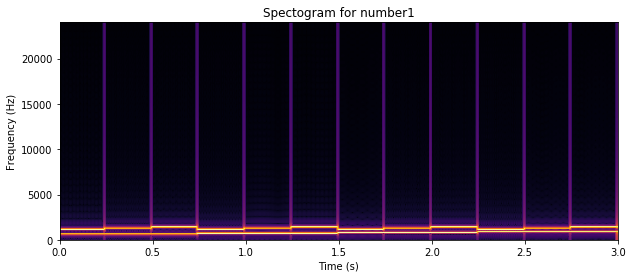

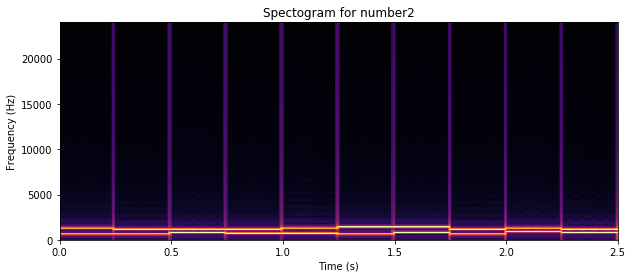

In [4]:
# STFT / inverse-STFT function definition
def stft_1d(input_sound, dft_size, hop_size, zero_pad, window):
    frames = []
    for i in range(int(len(input_sound) / hop_size)):
        idx = i * hop_size
        frame = input_sound[idx : idx + dft_size]
        frames.append(frame)
        
    sound_arr = None
    for frame in frames:
        # Add some zeroes to last frame
        if not len(frame) == dft_size:
            frame = np.pad(frame, (0, dft_size - len(frame)), 'constant')
        # Apply analysis window
        frame = frame * window
        # Add zero pad
        frame = np.pad(frame, (0, zero_pad), 'constant')
        # Apply fft
        fft_arr = np.fft.rfft(frame)
        # Stack complex vector as column
        if sound_arr is None:
            sound_arr = fft_arr
        else:
            sound_arr = np.column_stack((sound_arr, fft_arr))
    return sound_arr

def stft_2d(stft_output, dft_size, hop_size, zero_pad, window):
    # add extra dft_size at end to give some margin
    sound_arr = np.zeros(int(hop_size * len(stft_output[0])) + dft_size)
    for i in range(len(stft_output[0])):
        frame = stft_output[:,i]
        # Apply ifft
        ifft_arr = np.fft.irfft(frame)
        # Overlap-Add
        idx = i * hop_size
        sound_arr[idx:idx + dft_size] += ifft_arr[:dft_size] * window
    return sound_arr
    
# Checks dimension of input array and executes appropriate stft function
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    if np.ndim(input_sound) == 1:
        return stft_1d(input_sound, dft_size, hop_size, zero_pad, window)
    elif np.ndim(input_sound) == 2:
        return stft_2d(input_sound, dft_size, hop_size, zero_pad, window)
    else:
        return None

dft_size = 1024
hop_size = int(dft_size / 4) # 1/2 hop size produce bad reconstruction result
zero_pad = 64
specto_no1 = stft(number1, dft_size, hop_size, zero_pad, np.hanning(dft_size))
plt.figure(figsize=(10,4))
plt.set_cmap('inferno')
plt.title("Spectogram for number1")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(number1) / sample_rate, len(specto_no1[0])), np.linspace(0, sample_rate / 2, len(specto_no1)), np.absolute(specto_no1) ** 0.2)
plt.show()
specto_no2 = stft(number2, dft_size, hop_size, zero_pad, np.hanning(dft_size))
plt.figure(figsize=(10, 4))
plt.title("Spectogram for number2")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(number2) / sample_rate, len(specto_no2[0])), np.linspace(0, sample_rate / 2, len(specto_no2)), np.absolute(specto_no2) ** 0.2)
plt.show()

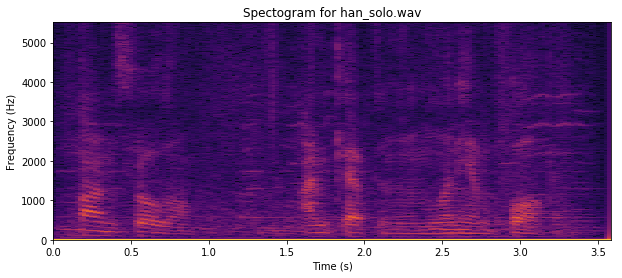

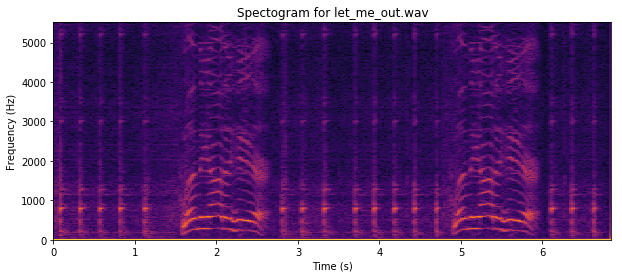

In [11]:
# STFT on real sounds
han_rate, han_arr = wavio.read("han_solo.wav")
IPython.display.display(IPython.display.Audio(han_arr, rate=han_rate))
specto_han = stft(han_arr, dft_size, hop_size, zero_pad, np.hanning(dft_size))
plt.figure(figsize=(10, 4))
plt.title("Spectogram for han_solo.wav")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(han_arr) / han_rate, len(specto_han[0])), np.linspace(0, han_rate / 2, len(specto_han)), np.absolute(specto_han) ** 0.2)
plt.show()
letme_rate, letme_arr = wavio.read("let_me_out.wav")
IPython.display.display(IPython.display.Audio(letme_arr, rate=letme_rate))
specto_letme = stft(letme_arr, dft_size, hop_size, zero_pad, np.hanning(dft_size))
plt.figure(figsize=(10, 4))
plt.title("Spectogram for let_me_out.wav")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(letme_arr) / letme_rate, len(specto_letme[0])), np.linspace(0, letme_rate / 2, len(specto_letme)), np.absolute(specto_letme) ** 0.2)
plt.show()

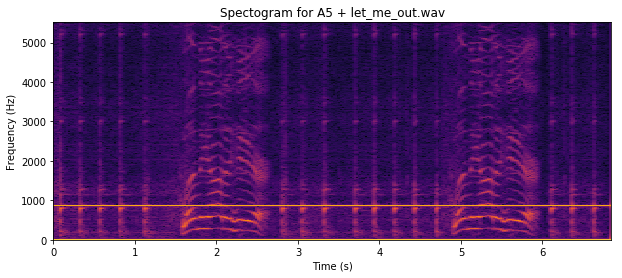

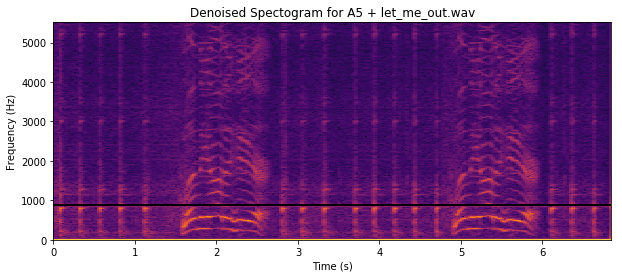

In [36]:
# Sound Synthesis
# A5 @ 880Hz
duration = 7
a4 = np.linspace(0, 880 * (len(letme_arr) / letme_rate), len(letme_arr))
a4 = np.sin(2 * np.pi * a4) * (10 ** 2)
synth_add = a4 + letme_arr
IPython.display.display(IPython.display.Audio(synth_add, rate=letme_rate))
specto_synth_add = stft(synth_add, dft_size, hop_size, zero_pad, np.hanning(dft_size))
plt.figure(figsize=(10, 4))
plt.title("Spectogram for A5 + let_me_out.wav")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(synth_add) / letme_rate, len(specto_synth_add[0])), np.linspace(0, letme_rate / 2, len(specto_synth_add)), np.absolute(specto_synth_add) ** 0.2)
plt.show()
# Denoise sinusoidal
specto_synth_add[85:90] = 0
plt.figure(figsize=(10, 4))
plt.title("Denoised Spectogram for A5 + let_me_out.wav")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.pcolormesh(np.linspace(0, len(synth_add) / letme_rate, len(specto_synth_add[0])), np.linspace(0, letme_rate / 2, len(specto_synth_add)), np.absolute(specto_synth_add) ** 0.2)
plt.show()
# Inverse STFT
denoised_add = stft(specto_synth_add, dft_size, hop_size, zero_pad, np.hanning(dft_size))
IPython.display.display(IPython.display.Audio(denoised_add, rate=letme_rate))